In [1]:
!pip install seaborn -U #Equivalent de ggplot dans python
#!pip list --outdated install
!pip install dfply #Equivalent de dplyr dans python
!pip install rpy2 #Utilisation de R studio
!pip install nltk wordcloud #Pour faire du nlp, et d'extraction de mots
nltk.download('punkt') #packages supplementaires
nltk.download('stopwords')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dfply import *
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.gridspec as gridspec

from rpy2 import *
from rpy2.robjects import *
from rpy2.robjects.packages import importr

def main(): 
    degrees = 4 
    grid = r.seq(0, 10, length=100) 
    values = [r.dchisq(x, degrees) for x in grid] 
    r.par(ann=0) 
    r.plot(grid, values, type='l') 

if __name__ == '__main__': 
     main()
#sns.set(style="ticks")
#print(rpy2.__version__)

In [4]:
donnee=pd.read_csv("globalterrorismdb_0718dist.csv",encoding="ISO-8859-1",low_memory=False)

In [3]:
import os
os.getcwd()

'C:\\Users\\Ange Steven AFFI\\Documents\\DataViz Project ENSAE'

In [23]:
#donnee.count()

# Thème: Térorisme en Afrique, mode opératoire, et prédiction

# Plan de travail

1. Tri à plat des données
2. Croisement des variables
3. Histoire à raconter

# Modes & Acteurs

1. [Modes opératoires: les outils,..., le nombre de victimes, occurrences (le nombre d'attaques), cibles,],les évolutions 

2. faire un mapping pour montrer les pays touchés, et les attaques en termes de volume; et zones des commanditaires.

In [21]:
#Les variables
##country_txt,region_txt,city, iyear,attacktype1_txt,attacktype2_txt,attacktype3_txt,
##targtype1_txt,targsubtype1_txt,target1,natlty1_txt,corp1,ransom, 
##natlty3_txt, gname, weaptype1_txt, weapsubtype1_txt, 
##addnotes, scite1-scite3

In [5]:
#Liste des pays africains
pays=pd.concat((pd.DataFrame(np.unique(donnee['country_txt'][donnee.region==10])).iloc[[0,2,10,11,17,
                            21]],pd.DataFrame(np.unique(donnee['country_txt'][donnee.region==11]))))[0]

In [5]:
#pays

In [6]:
#****Construction de données pour les statistiques descriptives
mode_donne_pays_anne=(donnee>>
 mask(X.country_txt.isin(pays))>>
 group_by(X.gname, X.weaptype1_txt)>>
 summarize(Effectif= n(X.weaptype1_txt))>>
 arrange(X.Effectif,ascending=False))

# Construction de données pour les statistiques descriptives

In [7]:
#****Les organismes terroristes encore presents en Afrique
Acteur_plus_actifs=(donnee>>
                    mask(X.iyear>=2009,X.country_txt.isin(pays))>>
                    group_by(X.gname)>>
                    summarize(Effectif= n(X.gname))>>
                    arrange(X.Effectif,ascending=False))
#>>arrange(X.Effectif))

In [121]:
#Acteur_plus_actifs

In [8]:
Acteur_plus_actifs.sort_values(by="Effectif",ascending=False).head(10)["gname"][1:10]

23                                Al-Shabaab
57                                Boko Haram
85                         Fulani extremists
226      Sinai Province of the Islamic State
252    Tripoli Province of the Islamic State
164                        Muslim extremists
115                                Janjaweed
28            Allied Democratic Forces (ADF)
131             Lord's Resistance Army (LRA)
Name: gname, dtype: object

Text(0.5,1,'Top 10 Active Terrorist Organizations in Africa')

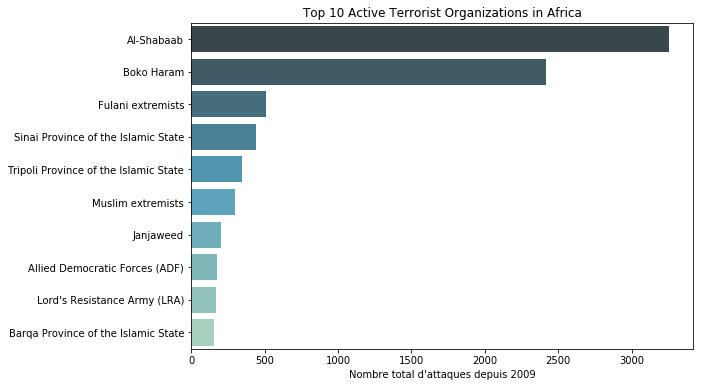

In [10]:
#Representation des 1O organismes terroristes les plus présents ces 7 dernieres années
f, ax = plt.subplots(figsize=(9, 6)) 
sns.barplot( y = Acteur_plus_actifs.sort_values(by="Effectif",ascending=False).head(11)["gname"][1:11],
            x = Acteur_plus_actifs.sort_values(by="Effectif",ascending=False).head(11)["Effectif"][1:11],
                palette="GnBu_d")
ax.set_ylabel('')
ax.set_xlabel("Nombre total d'attaques depuis 2009")
ax.set_title('Top 10 Active Terrorist Organizations in Africa')

In [11]:
Acteur_plus_actifs.name=Acteur_plus_actifs.sort_values(by="Effectif",ascending=False).head(10)["gname"].unique()[1:]

C:\Users\Ange Steven AFFI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [12]:
#Table de données contenant le nombre d'attaque des groupes terroristes selon les pays
terror_filter=(donnee>>
                    mask(X.country_txt.isin(pays),X.gname.isin(Acteur_plus_actifs.name))>>
                    group_by(X.country_txt,X.iyear,X.gname)>>
                    summarize(Effectif= n(X.gname))
               )

In [13]:
terror_filter=terror_filter[['gname','country_txt','iyear','Effectif']]

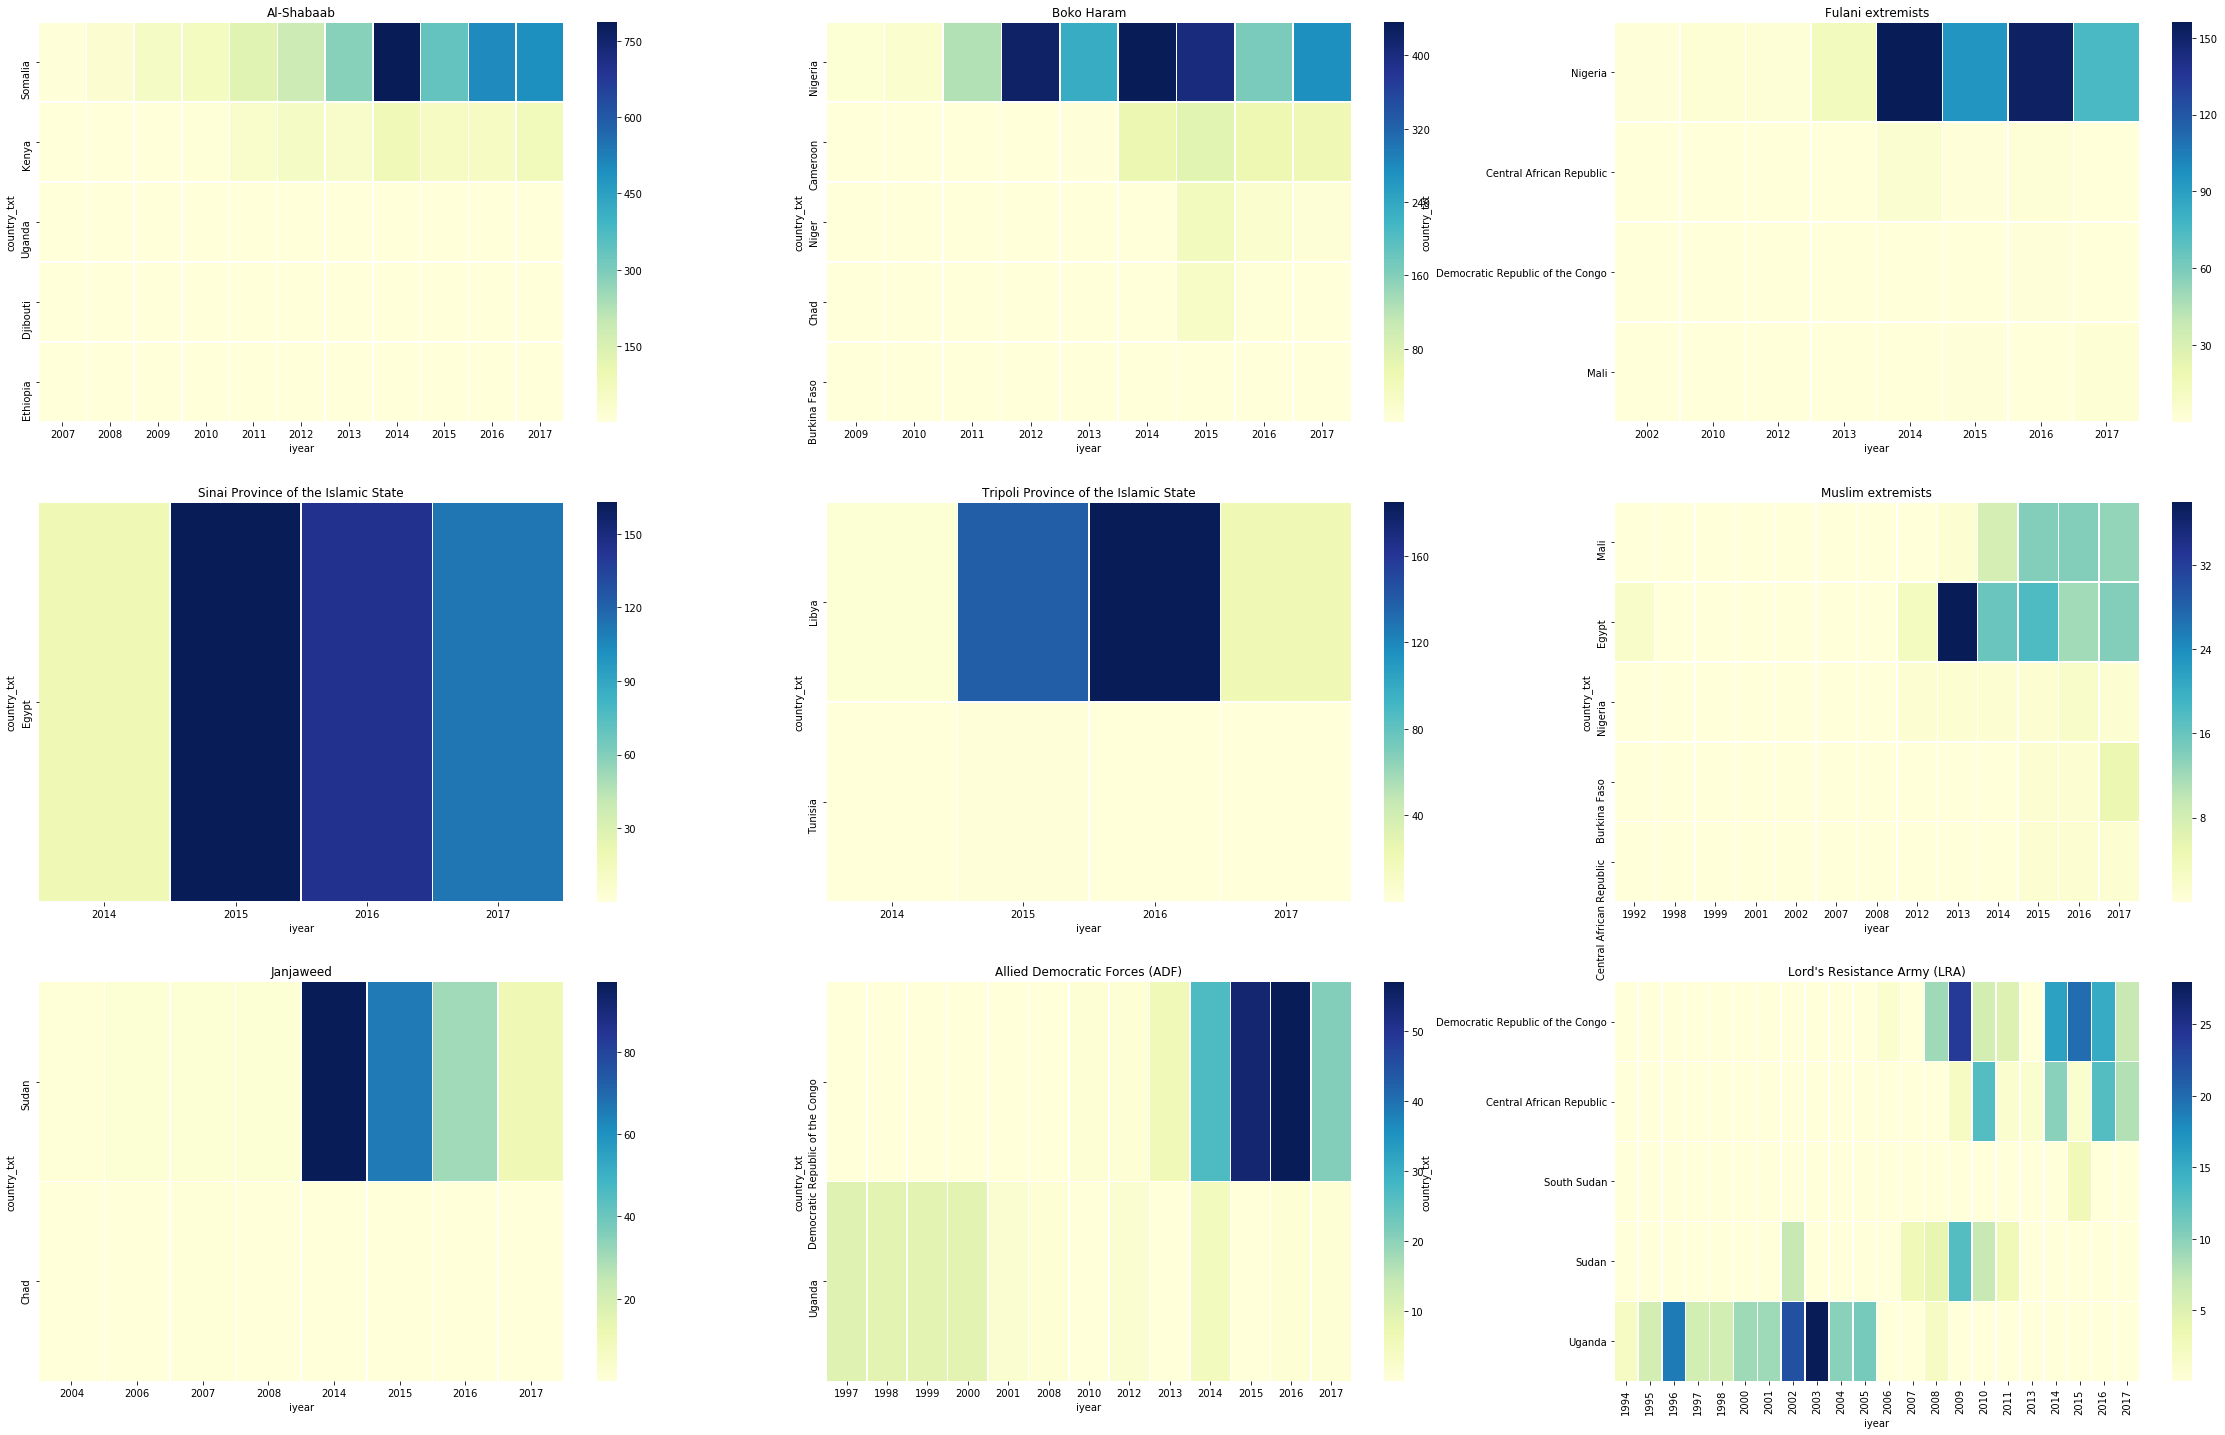

In [14]:
#Evolution du nombre d'attaques des 5 pays les plus touchés par groupe terroristes(10 groupes 
# les plus actifs en Afrique ces 7 dernières années). 

plt.subplots(3, 3,figsize=(40, 25))
i=1
for x in Acteur_plus_actifs.name:
    terror_filter_k=terror_filter[terror_filter.gname==x][['country_txt','iyear','Effectif']]
    terror_filter_k=terror_filter_k.pivot(index='country_txt', columns='iyear', values='Effectif').fillna(0)
    terror_filter_k = terror_filter_k.sort_values([2016], ascending=False)
    ax=plt.subplot(3,3,i) 
    g = sns.heatmap(terror_filter_k[0:5],cmap='YlGnBu',linewidths=.5,vmin=0.01)
    ax.set_title(str(x))
    #ax.set_title(str(x))
    i=i+1
plt.show()
#PuBuGn','YlGnBu,BuGn',RdYlBu,Pastel2,YlOrBr,YlOrRd,wistia

In [15]:
#Filtre des données pour l'Afrique et pour les acteurs les plus actifs
df=donnee>>mask(X.country_txt.isin(pays),X.gname.isin(Acteur_plus_actifs.name))

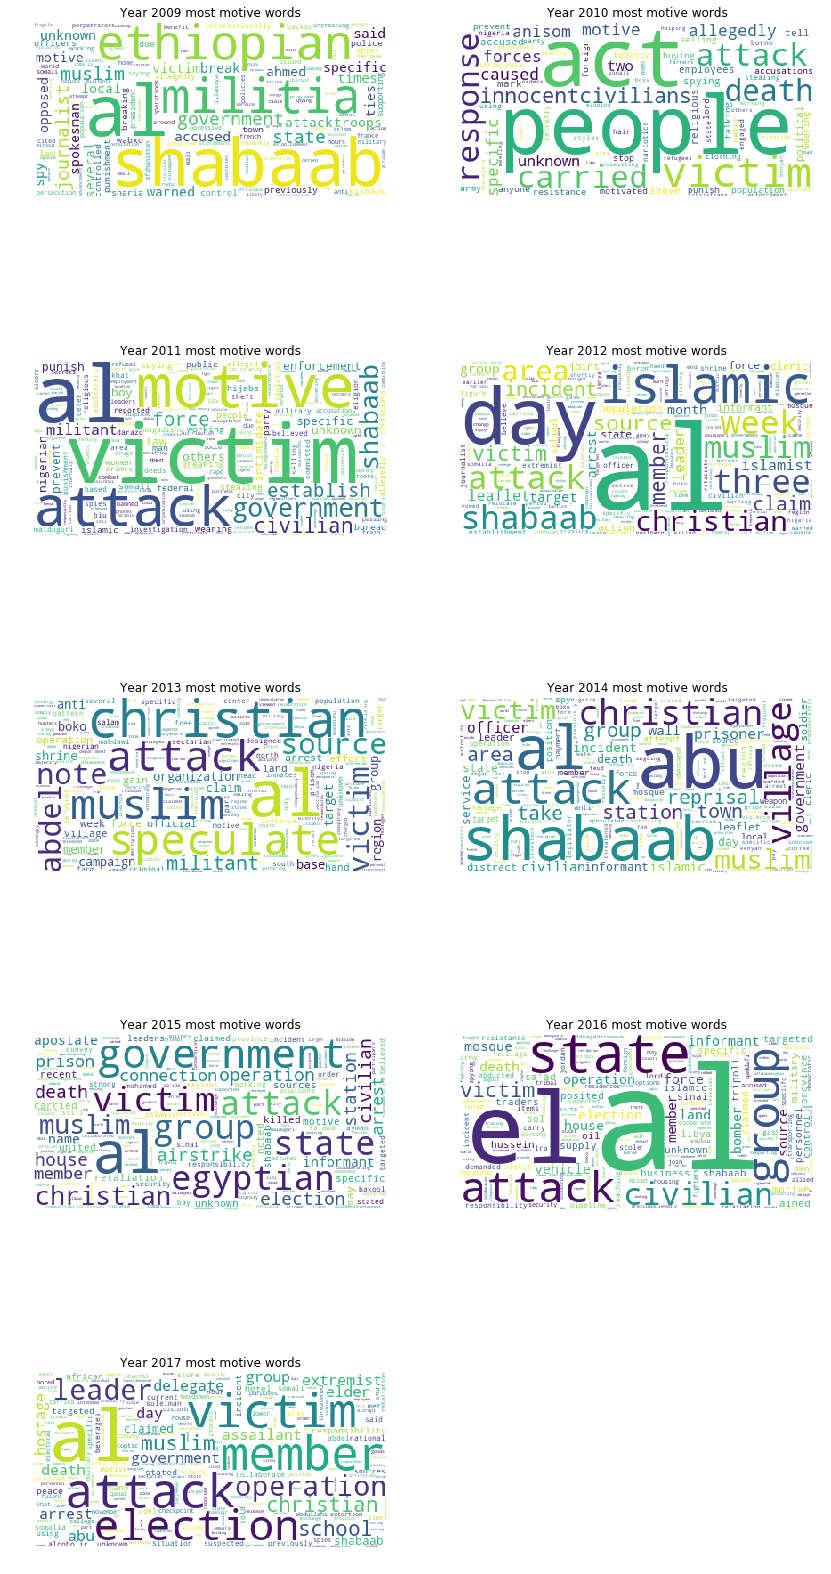

In [16]:
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017]
plt.figure(figsize=(14,30))
gs=gridspec.GridSpec(5, 2)
for i, cn in enumerate(years):
    ax = plt.subplot(gs[i])
    df_country = df[df['iyear'] == cn]
    country_motive = df_country['motive'].str.lower().str.cat(sep=' ')
    words=nltk.tokenize.word_tokenize(country_motive)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(" ".join(words_except_stop_dist))
    ax.imshow(wordcloud)
    ax.set_title('Year ' + str(cn) + ' most motive words')
    ax.axis('off')

(-0.5, 399.5, 199.5, -0.5)

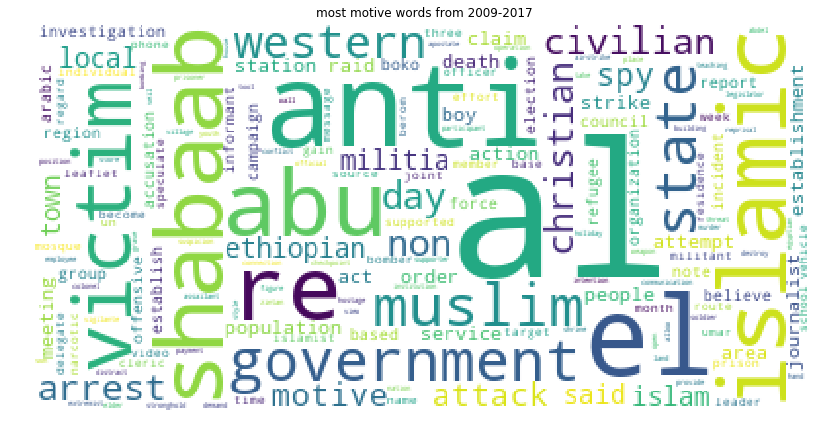

In [22]:
#Representation des motifs d'attaques ces 8 dernières années.
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017]
plt.figure(figsize=(14,30))
#gs=gridspec.GridSpec(1, 1)
#plt.subplot(gs[i])
df_country = df[df.iyear.isin(years)]
country_motive = df_country['motive'].str.lower().str.cat(sep=' ')
words=nltk.tokenize.word_tokenize(country_motive)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud)
plt.title('most motive words from 2009-2017')
plt.axis('off')

In [27]:
!pip install codecs

  Could not find a version that satisfies the requirement codecs (from versions: )
No matching distribution found for codecs


In [28]:
from scipy.misc import imread
import codecs
import base64

In [55]:
kaggle=b'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJYAlgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAK83+Oelf2n8Lr6RV3SWMsd0o+h2sfwV2NekVn67piazoGo6XJjbeW0kBz23KRn9aAPhCinSI8UjRyKVdCVZT1BFNoA9T/AGf9UFj8SltWI239pLCM/wB4YkH/AKAfzr6sr4d8F6t/YfjbRdSLbUgvIzIf9gsA3/jpNfcVABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHxZ8TdI/sT4k69ZhdqG6MyAdAsmJAB9A2Pwrk69m/aO0n7N4v03VFXC3toYyfV425/R1rxmgAr7i8Gat/bvgrRtT3Ze4tI2kP8AtgYb/wAeBr4dr6p/Z91b7d8OTZM2X0+7kiA9FbDg/mzflQB6tRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHj/7RWmfavAtnqCrl7K9XcfRHUg/+PBK+YK+6PE3h2y8V+HbzRNQMgt7pQGaMgMpBDAjPcECvnb41fDjT/B1rot7ots8dkyG1uHZtxaUfMrN/tMN3Tj5egoA8gr6f+BXgvX/AArZ395qghjtdThhlhiWTc4I3EEgcDhvX09K+YK+5PB14uoeCtDu1ORLYQsfY7BkfnmgDbooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBskiRRtJI6pGgLMzHAUDqSa8G+JXxM8LeNfDeqeGtMN5Ldxj7RBcmICFzF87YJbd9wPj5a9o8RmxHhnVP7TlMVgbSVbhx1WMqQx+uM18KBipypIOCOPegBK+jvhN8UvDejfDu30/XtWS0uLKV4lRkd2ZCdykBQTj5iPwr5xooA+pdR/aG8HWoItIdSvW7GOEIv5sQf0rkdS/aVvX3DS/DtvF/de6uGkz/wFQv8AOud+Dvw50Hx6uqSatdXiyWTx7Ybd1QMrBuSSCf4T0xXb+NP2fLe7WyPg5rayMastyt7PIRJ0wwOG56gjAHSgDzrUvjn471DcI9SgskbqtrbqP1bcw/Oui+E/xZ8Qv4wtNG1y/l1Cz1CTylabl4pD90g9cE4BB9cj34Tx38PNU+H9xYw6lcW0/wBsjZ0e3LFQVIBHzAeo/OvQvgB4Ee81I+Lr6PFralo7JWH+skxhn+igkfU+1AH0fRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBU1XT4tW0i902fPk3cDwPj+6ylT/OvCPEXwu+Hfw/8ADaTeJNQ1O6vJSfJMB2NMy4JRVAIUHuWPfg9K+gq8E/aU1Ira6Fpf2YbXeS488/7IC7R/31k/hQB8+NjcdoIXPAJyaSiigD1z9njVvsXj+fT2b5L+zdQPV0IYf+Oh6+jdc8TaJ4bgWXWNTtbMMCUWWQBnwOdq9T+FfGXg/X/+EX8X6XrRR3S0nDyKn3mQ8MB7lSam8beLr3xt4muNXuxsVvkggzkQxjoo/mT3JNAHWSyar8b/AIoqi+ZDYDgDqLW2U8n03HP4swHSvqbTNNtNH0y206whENrbRiOKMdgP5n3r5+/Zy8QWFpqWp6HOkUd5eBZYJjw0m0HMefbO4D/er6MoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvOPjXqeh6d4CuV1a0W5ubpXt7H92paOUrneCfugYBOOvAr0euM+J3hXS/FHg27OpiYf2fFJdwvC4VgyoTjkEYPfigD4zooooAK1pvDWrw6Da639ilfTbgMVuY1LIhVipVyPunIzg9iKya0rHxFrWl27W1hq19bW7gh4Yp2WNgeoKg4Oe+RQBQhmlt5o5oJHiljYMjoxVlI6EEdDXt/wAMvjlNYNFo/i6eS4tScRai5LyR57Sd2X/a6j3HTyq88L3cHhLT/EsP76wuZHglYD/UTKx+VvqoDA+5HbnCoA++re4hu7eO4t5UmhkUMkkbBlYHoQR1FS18a+Cfij4i8DnybKZbnTyctZXOSgPcqeqn6ceoNfSHgD4paL4+Vre3SSz1OKPfLaSkHI6Eo38QHHYHnpQB3VFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRR0rzTxV8cPCnhudrW3kk1W7UkMlmQUQ+hc8flmgD0uivlbxD8fvFuqzMNLMGkW2flWJBJIR7sw/kBXH3fxF8Z3rZm8UaqPaO6aMfkpAoA+2aK+LbL4n+OLBgYfE+otj/AJ7y+d/6Hmu/8N/tF6vZqsPiHTotRTPNxARDJj3XG0/htoA+k6K5Xwj8RPDnjWL/AIlV7i5Ay9pOAky/8BzyPcEiuqoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvmX47eOdZuPFF34Ujka20u1Ee+NDg3BZA+WI6qN3A6cZPPT6ar5h/aK0v7L45stQVcJe2YDH1dGIP/AI6UoA8eooooAKKKKAPRPDV5qmo/B/xR4f063+0eVdQXsydWWHneyj2aOPPsTXndelfAzVBYfEmCzdsQ6lby2j5AI6bxweOqAfjXF+JPD974W8QXmj6gm2e2cruxgSL/AAuPYjmgDJq9o+sX+gatb6pply1veW7bo5FAOOx4PBBHGDVGigD73sPtP9nW32xla68pfOKjAL4G7A7c5qxXz74L/aD8uPS9J8Q6cCBtgm1NJ8YHQOybfpk7vU47V9AghlDKQQRkEd6AFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsPxT4u0bwdpTX+sXSxJyI4l5klb0Ve5/Qd6o+PPHem+A9DN9efvbmXK2tqpw0zj+SjjJ7fUgV8ieKfFOqeMNcm1XVZt8r8JGv3Ik7Ko7Afr1PNAHT+Ovi54g8Y3MsMU8unaSflWzgkI3r/00YfeJ9Ont3rz6iigAooooAKKKKAHxSyQTJNDI8cqHcroxBU+oI6V7R4A+Pd9phi07xZ5l9Z8Kt6ozNGP9r++Pf73Xr0rxSigD7z0zVLHWtPhv9Nuorq0mGUlibIP+B9jyKuV8W+A/iBq3gPVhcWTmWylYfabN2+SUf+ysOxH6jivrnwv4n03xfoMGr6XKXgk+VlYYaNx1Rh2I/wACODQBs0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4t+0hpf2jwnpWpquWtLsxH2WReT+aL+de01xnxY0s6v8L9egVcvFb/AGhfUeWQ5/RSPxoA+M6KKKACiiigDR0HVH0TxDp2qR53WdzHPgd9rA4/HFfXnxA8EWHxA8LPCBGL1U82xuscq2MgE/3W6H656gV8ZV9n/CzWP7b+Gmh3RbMkduLeT13RnZz9doP40AfG95Z3Gn3s9ndwtDcwSGOWNxgqwOCDUFezftAeC59O8RDxVbgvZaiVjmwP9VMqgD8GC5+ob2rxmgCW3t5ru5itraF5p5WCRxxqWZ2PAAA6mvs34aafrWlfD/S7LX2Y38UZBRjlo0ydiE9yFwPbp2r4ytrmazuobq2laKeFxJHIpwVYHII/Gvs34c+NIfHHhK31EFVvI/3V5EP4JQOTj0PUfXHY0AdbRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVieKvFeleDtEk1XVpikSnbGijLyvjhVHqcfQd62JZEhieWV1SNFLMzHAUDqSa+Pvir48fxz4paS3ZhpVnmKzQ9x3kI9Wx+QAoAw/GPi3UPGniGfVtQbBY7YYQflhjB4Uf49zk1gUUUAFFFFABRRRQAUUUUAFFFFABXb/DT4hXfgLXhKd8ulXLBby3HcdnX/AGhn8enuOIooA++LO7t9QsoLy0lWa2njWSKRTw6kZBH4VPXiP7PHi5r7R7vwxcvmWx/f22T1iY/Mv4Mc/wDA/avbqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKhu7aO9s57WYZinjaNx6qwwf51NRQB8EXtpJYX9xZzcS28rRP8AVSQf5VXrt/i7pf8AZPxR1yILhJ5hcqfXzFDn/wAeLD8K4igAooooAK+j/wBm7WPO0DWNGdvmtrhbhAf7rrg4+hT/AMer5wr1L4Bax/ZvxJjtGbEeo20kHPTcPnH/AKAR+NAH0t4n8P2vijw3f6LdgeVdRFQ2M7G6qw9wQD+FfEWp6dc6Rql1p17H5dzaytFKvoynB/D3r70r55/aH8GmK6tvFtpH8kuLe92jowHyOfqBtP0X1oA8GrufhX45fwP4tjmmdv7Lu8Q3iDsvZ/qp5+mR3rhqKAPv2ORJY1kjdXjcBlZTkMD0INOrxj4BeOv7W0V/C9/Lm809N1qWPMkHTb9VPH0I9DXs9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHjfx/8Z/2T4fj8NWjst3qa75mU42wA9P8AgRGPoG9a+ZK9Y/aGJPxJiyc40+LH/fT15PQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBu+DvEU/hXxZp2sQyMqwTL5wX+OInDr+Iz+lfcKsGUMpBUjIIPBr4Br7d8BXzaj8P/D905y72EIc56sFAP6g0AdFRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzZ+0jpfkeJ9I1RVwt1aNCxA6tG2f5OPyrxOvqH9ojSxd+ArW/UfPZXikn0RwVP67K+XqACiiigArU8Oaq2heJtM1VSf8ARLqOYgdwrAkfiMisuigD79R1kRXRgysMgjoRVLW9HtPEGiXmk36b7W7iMbjuM9CPcHBHuKwPhhrH9ufDbQ7wtukW2EEh77o/kJP125/GuuoA+GPFPhy88KeI7zRr5f3tu+FfGBInVXHsRzWPX1R8cPAX/CTeHP7asId2qaYhYhRzNB1Zfcj7w/Ed6+V6ANPw/rl54a1+z1iwfbcWsgdQejDup9iMg/Wvtfw5r9l4o8P2es6e+be5j3AHqjdGU+4OQfpXwrXr/wACfHv9ga6fDt/LjTtSkHksx4in6D8G4H1C+9AH1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzh+0jo5h17R9ZUHZc27WznsGRtw/MP/wCO14fX1r8dLPTbn4Y3k1+SsttLHJaMvXzSduPoQWz+favkqgAooooAKKKKACiiigAooooAKKKKACiiigAr7W+G1rJZfDbw9DKMP9hjcj03DcP0NfHGh2Uep6/pthNIY4rq6ihdwMlQzAE/rX3bFEkEKRRIEjRQqqOgA4AoAfRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHL/ABH0v+2fhzr1kF3O1m8iLjqyfOv6qK+KK+/XRZEZHUMrDBB6EV8Ja7praN4g1HTHzus7qSA577WI/pQBn0UUUAFFFFAH0n+zfrH2jwzq2ju2Ws7lZkB/uyLjA/FCf+BV7ZXyn8AdYOnfEhLJmxHqNtJDgnjco3g/X5SPxr6soAK+TPjP4B/4RDxN9vsYtukaixkiwOIpOrR+w7j2OO1fWdYXjDwvZ+MfDN3o14ABMuYpcZMUg+64+h/MEjvQB8O0oJBBBwR0Iq5q+lXmh6vdaXqERiurWQxyKfUdx6g9Qe4NUqAPrz4QePP+E08KLHdyZ1awCxXWTzIMfLJ+ODn3B9RXodfE/gHxdP4J8W2mrR7mgB8u6iX/AJaRH7w+o4I9wK+0bO7t9QsoLy0lWa2njWSKRTw6kZBH4UAT0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHgX7SmrSLDoWjo2InaS6kX1Iwqfzf86+fa9m/aQnLeNtLt+cJpwf2+aRx/7LXjNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkE0ltcRzxNtkjcOh9CDkV9W/D74zaV40vE0q6t207VWX92jPujnIGTtOBg8E4Pbua+Tq6DwNfWOmeOtEvtTkaOzt7yOSR1/hwcgn2Bxn2zQB9v0U1HWRFdGDKwyrKcgj1p1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfInxv0r+zPilqLqMR3iR3SDHquG/8eVq+u6+ev2ldLC3Wg6so5dJbZz/ukMv/AKE9AHgtFFFABRRRQBp+HdWfQfEmm6smSbO5jmIH8QVgSPxGR+NfdEM0dxBHPC4eKRQ6MOhBGQa+BK+yvhLq/wDbPww0Sdm3SQw/Zn9QYyUGfwAP40AdrRRRQB4l8fPAP9paaPFmnRf6XZptvVUcyQ9n+q9/9n/dr5tr79kjSWNo5EV43BVlYZDA9QRXyB8WPAL+B/E7C2RjpN6TLaOf4P70ZPqufyI96AOBr6E/Z78bvNHN4QvpMmJWnsWY87erx/hncP8AgXpXz3V3SNVu9D1i01Sxk8u6tZVljb3HY+oPQj0NAH3lRWR4Z8QWninw5ZazZH9zdRhipPKN0ZT7g5H4Vr0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzH+0Xpl3F42s9SaF/sc9kkSTY+XerPlc+uCD+NeOV9WftAFP8AhWLbpChN7DtAXO8/Nx7cZOfbHevlOgAooooAKKKKACiiigAooooAKKKKACiiigAooqW1tp727htbaJpZ5nEccajlmJwAPxoA+ufgnqM2o/CvSjO5d7cyW4Y/3Vc7R+C4H4V6DWP4V0KLwz4W03RoQuLSBUcqOGfqzfixJ/GtigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvKv2gtNN78NTdAc2N5FMT7NmP+bivVawvGejHxB4M1jSkXdLc2rrEP+mmMp/48BQB8O0VMlpcyTPClvK0sYYuioSyhfvZHbGDn0xUNABRRRQBteGfCmseMNTfT9EtRcXCRGZwZFQKgIBOWI7sPzr6s+E3hHUvBfgoabqssbXUlw85SNtyxBgoC57/dz+NfK3g7xJceE/FVhrFu7gQSjzkU48yIn51Prkfrg9q+3oJ4rq3iuIHEkMqB0cdGUjIP5UASUUUUAFc7438I2fjXwxc6Rd4R2G+3mxkxSj7rfTsR3BNdFRQB8Garpl3ouq3WmX8RiuraQxyoexH8x3B7iqdfSXx6+H/9p6f/AMJZpsObu0Tbeoo5kiHR/qvf/Z/3a+baAPXfgT47bQfEQ8PXsuNO1OQCIseIp+in6Nwv12+9fUVfAKsyOroxVlOQQcEGvsv4XeL/APhMvA9nezSq1/CPIvAOvmL/ABH/AHhhvxPpQB2dFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHif7Rmvx23h7T9B+z75LyU3HmnpGI+OPc7vyB9a+bK+of2hPDj6p4Lt9Xgj3TaXNufHURPgN+TBPwzXy9QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVueD9bi8OeMNK1ieEzQ2lwskiDqV6HHuAcj3FYdFAH31a3MN7aQ3VtIJIJ0WSN16MpGQR9QalryH4AeLP7Y8JS6FcSZutKYCPPVoWyV/I5H02169QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz3iPTbe28M+IbrT7S3t7+ewnzPFCod22NgkgZbn1r4hr75u4UuLKeCUgRyRsjE9ACMGvjDxPpHhjQ7OOy07WZdY1cOPPuIFCWkY5yqkjMhzj5gQOPyAOVooooA9A+HPhfwlrFvf6h4w1xdOtYGWO3iW4RJJmwSx2kFiANvQcluvGK9a/wCF4+B/C+k2mk6NHqWpQ2kSwxME2jaowMs5B/8AHa+ZaKAPoi9/aVsltl+weHLh5yORPcKqqfwBJ/SovB37Qd1qXiaGx8RWNjbWNy4jjntwymFicAvuYgr2J4x1r58p7RSJGkjIwR87GI4bHXFAH35RXJ/DXXz4l+Huj6hI5efyBDOWOSZE+Rifc4z+NdZQA10SSNo5FVkYEMrDIIPY18h/FrwA/gjxMz2kTf2PekyWrdRGf4oyfbt7Ed819fVgeMvCll4z8M3Wj3oC+YN0MuMmKQfdYf19QSKAPh+vQ/g945/4Q3xesd3Jt0rUNsFzk8RnPySfgSc+xNcXrWj3ugaxdaVqMJiu7aQpIvb2I9QRgg+hqhQB9/8AWivLfgf44bxR4VOl3sm7UtLCxlieZYv4G+oxtP0B716lQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBwfxl1M6Z8LNZZcb7hEtlz/ALbAN/47ur48r66+OFo938KtTMcZdoXilOOwDjJ/ImvkWgAooooAKKKKACiiigAooooAKKKKACiiigAooooA9Q+AU5i+KEEe8qJrWZMD+Ljdg/ln8K+r6+NvhNrdroHxL0i8vMiB3a3Zh/AZFKAn2BIz7V9k0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSMyqMswGTgZPc0tABRRRQAUUUUAFFFcR8S/H8Xgfw1Jd2ptbjUnkWKG3kk6E5yzKDnAAP44oA7eivi+T4o+NX1w6uPEF2t10CqR5QHp5ZGzH1FU9X8e+LNd3DUfEF/KjdY1lMcZ/wCALhf0oA+jfjX4sstL8Aajp1vqEH9pXhW3ECSgyBScuSoOQNoI/Gvk+iigAooooAKKKKAOq+HvhODxr4vt9Fub5rOOVHfeqBmbaMlRk9cZ59ulenfHLwTp/hzwX4bOkwGO2sZpLVieWfzBv3Me5yjf99fSvKvAWrDQ/Huh6izbY4rtBI3ojHa//jrGvqP4waT/AGv8LtajVcyW8YukPp5ZDN/46GoA89/Zt13dbazoEjcoy3kI9j8j/wAk/Ove6+OPhFrv9gfEvSZnfbDcyfZJfQiT5Rn2DbT+FfY9ABRRRQB5X8ZfhqPF2k/2vpcI/tqyT7qj/j5iHJT/AHh1X8R3GPlUgqxVgQQcEHtX39Xzp8dPhp9imk8XaPB/o8rZ1CFB/q3P/LUexPX357nAB5d4G8WXHgvxZZ6xDuaJG2XEQP8ArYj95fr3HuBX2pZXtvqVhb31pKsttcRrLFIvRlIyD+VfBFfRH7Pfjfz7abwhfS/vIQZrEseqdXT8D8w9i3pQB7vRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFTU7WzvtKu7XUFRrKaFknDnA2EfNk9uO9fCV4lvHfXCWkrS2yysIpGGC6Z4JHYkYr6V+O3j9NF0R/C9i+dQ1CL9+yn/Uwk8j6tgjHpn1FfMdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJVgykgg5BHavu/Q706l4f02/Ygm5tYpiR/tID/AFr4Pr7N+FF4b74W+H5mOStt5Oc5+4xT/wBloA7KiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5A+L3inUtc8d6rYz30smn2N00MFvnCIV+UnA6nIPJ5rg4p5oM+VK8e7rsYjNdT8T4o4fid4iWNQqm9diB6nkn8SSa5KgDRi8Qa1blTDq9/HtGF2XLjA/A1ow+PvGFuMR+KNYAAwA17IwA9gTxXO0UAdbH8UPHEa7V8T6gR/tSbj+ZpknxL8bSNubxPqYP8AszlR+QrlaKANe98V+ItSBF9r2p3Kn+Ga7kYfkT71kUUUAFFFFABRRRQAUUUUAFFFFAB0r7g0C7i8V+A7C4nO9NR09RNz3ZMOPzyK+H6+rPgDq39ofDZLRmy+n3MkGD12nDj/ANDI/CgD5durefS9UmtnJS4tZmjJHBDK2P5ivt7wtrSeIvCul6uuP9LtkkYDs+PmH4NkfhXyl8YtJ/sj4o6wiriO5dbpD6+YAzf+Pbq9i/Z2137d4MvNHdsyadc5QekcnzD/AMeD/nQB7FRRRQAVFcW8N1bS29xGssMqFJEcZDKRggj0qWigD4++Knw8m8CeIM26s+j3hL2kp52esbH1Hb1GD6447SNVu9D1e11Swl8u6tZBJG3uOx9QehHoa+2fFPhqw8XeHrrR9RTMUy/K4HzROPuuvuD/AFHQ18Y+KPDd/wCE/EF1o+opiaFvlcD5ZEP3XX2I/wAKAPszwn4ltPF3hmz1qz4S4T5485MbjhlP0P58HvW3Xyv8DfHf/CN+Jf7Fvptul6m4UFjxFP0VvYH7p/4D6V9UUAFFFFABRRRQAUUUUAFFFFABWT4m1628MeG7/WrvmK0iL7c4Lt0VR7kkD8a1q8/+M2gaj4i+HV1b6YjS3EEqXJhT70qrnKgdzznHfHrigD5P1vWL3xBrV3quoSmW6upC7t2HoB6ADAA9BVCjpRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfZnwmsjYfCzw/CRjdbGb/v4zP/AOzV8faZp8+rarZ6dbDM93MkEYP95iAP5191abYRaXpVnp0H+ptYEgj/AN1VCj9BQBaooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+MPip/yVDxD/ANfZ/kK4+uw+Kf8AyVDxD/19n+Qrj6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr3L9mzVvK1rWtHZuJ7dLlAfVG2n/wBDH5V4bXc/CDVv7I+KOiyM2I7iU2rj18wFVH/fRWgDu/2k9J8vVtE1hV/10D2zn02NuX897flXN/AXXf7J+I0dlI+2HU4Xtzk8bx86n6/KR/wKvX/j7pP9o/DOW6Vcvp9zHcZ74JKH/wBDB/CvlvS9Qm0jV7PUrf8A11pOk8f1VgR/KgD70oqvYXkOo6fbX1u26C5iWaM+qsAR+hqxQAUUUUAFcD8VPh3D470DNuqx6zaKWtJTxv8AWNj6Hsex59c99RQB8DXNtcWN3La3MTw3ELlJI3GGRgcEEetfWnwe8df8Jl4TWG7l3atp4WG5yeZF/hk/EDB9wfWsL4zfCv8A4SO2k8RaHB/xN4V/fwIObpB3A/vgfmOOoFeEeA/F1z4I8W2urRhmhU+XdQj/AJaRH7w+o6j3AoA+2aKr2V7balYwXtnMs1tcRiSKRTwykZBqxQAUUUUAFFFFABRRRQAUUUUAfGfxV0GTw/8AEjWLdo9sNxMbuA4wCkh3cewJZf8AgNcZX1z8XPh0vjjQftFkgGtWKlrY5x5q9TGfr29D7E18kzQy288kE0bRyxsUdHGCrA4II7EUAMooooAKKKKACiiigAooooAKKKKACiiigAooooA9N+A+jRat8TIZpvu6fbPdqP7zAqg/Ivn8K+sq+aP2bpAPGOrR5X5rDOO/Ei/419L0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHxJ8QYpIviN4kWVSGOp3DAH+6ZGI/Qiubr0H4y6HqOl/EbU7u8tmjtr+Uy20v8Mi4GcH1HcV59QAUUUUAFFFFABRRTkR5HCIrMzHAVRkmgBtFKysjsjqVZTggjBBqexsLzU7yOzsLWa6uZDhIYULu3GeAOelAFeirF5Y3en3Bt721ntp16xzxlGH4Hmq9ABRRRQAUUUUAFT2d1LY3tvdwnEsEiyofRlOR/KoKKAPuDWraLxb4DvYIRuTU9PYw/V0yh/Mg18QEEEgjBHUGvsL4Oat/a/wALtHZmzJbI1q4z02MQo/752/nXzB8QNJ/sP4ga7p4Xakd27xr6I53r/wCOsKAPpD4F69/bPw2trZ2zPpsrWr+u37yH6bWA/wCA16XXzN+zpr32LxbfaLI5EeoW++MZ/wCWkfP/AKCW/KvpmgAooooAKKKKACvC/jB8H/t4n8S+Grf/AEvl7yyjH+u9XQf3vUd+o56+6UUAfNnwQ+Jg0e5TwprMuLCd/wDQ5nPEEhP3D/ssenofrx9J14h8XPg4mqJceIvDNvt1DJkurNBxP6sg7P3I/i+vW58FfiaddtV8M61NjVrZMW8sh5uI1HQ56uoH4jnsaAPY6KKKACiiigAooooAKKKKACvj/wCNVmLP4sa0Fi8uOYxTL/tbol3H/vrdX2BXzn+0npKRaxomrpHhriGS3kYd9hBXPv8AOfy9qAPDKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOq+HHiJvC/j3SdSL7YPOENxzx5T/K2fpnP1Ar7Vr4Ar3P4T/Gh7FodA8VXLSWrEJbX8jZMPosh7r6N278dAD6MopAQyhlIIIyCO9LQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBVvdOsdSiWK/sre6jU7lSeJXAPrgisubwR4TnJMvhjRnJGMtYRZx9dtb1FAHIT/C7wNcff8M2AyMfu0Kf+gkVTk+DXw/lUBvDsYwc/LcTL/J67uigDzl/gZ4AZyw0iZAf4VvJcD82qeD4KfD6DB/sASMB1kupmz+G/H6V39FAHLWvw28FWf8AqvC+ln/rrbrJ/wChZres9M0/Txiysba2HpDCqfyFW6KAPmz9oTwfFpusW3ia1CJFqB8meNUx+9AJ3Z/2h+qk967n4HeCtF03wvZ+J4C1zqN/EQ0smMQgMVZEHbleT1OO3StX436T/anwu1B1XdJZPHdJ/wABO1v/AB1mrwW18e6ppnwjh0HTruS2kOoyiWSJ9riEorBQRyAWL5+n1oA+hPil4PHjrwhPY2P2d9UtZFlty7DKnOGXPbIz7ZA9K+PCCrFWBBBwQe1XtK1rU9D1Bb/S76e0ulP+sicgn2PqPY8VVurh7u7muZdvmTSNI+0YGScnA7UARUUUUAFFFFABRRRQB6d8N/i6/wAP9Du9NbSDqCTXPnp/pPlBMqA38LZ+6v61i/E7xRpnjLxPDrmmwywNPaItzDKOUlUsvUcEbQmD/KuLooA2PCmtt4c8WaXrCk4tLlJHA6lM4YfipI/GvuVHWSNZEYMjAFWB4IPevgKvrn4Ia+dc+GlnHI5afTnazck84XBT8NjKPwoA9GooooAKKKKACiivAPjxqXjTRvEFhf2V7dWmiogWCS0lZR53VvMx39AcjA4/ioA9/rxz4ofCaW/vG8V+Es22twt50kEXy+ewOd6HtJ/6F9etv4V/GC38WpFo2tMlvrirhH6JdYHUej+q/iPQesUAef8Aww+IsfjTTHs78C31+yG27t2G0tjgyAdueo7H8K7qG7triWaKC4hlkgbZMiOGMbYzhgOhx614n8bZtB8M6nY63ptxPp/jEnzIZLRRiRM4JmB4I6gHnPQgjpm/CjxfB4R0q91LxRZasn9tXH2k6v5Blt3AyOSuSDuLk8d/agD6EorloPiT4KuYfNTxRpQUDOJLlUP5Ng1Wn+K/gS3OH8S2Z5x+73P/AOgg0AdlRXnk3xw+H8RAXWnl9dlnNx+aiqcvx98Cx7ttxfSY6bLU/N9M4/WgD0+ivIpP2i/ByPhbHWpB/eWCPH6yCuX8SftHzSK0PhrSPKyOLm/ILD6RqcA/Vj9KAPedT1Sw0awkvtSvIbS1j+9LM4VR7fX2r5t+M3xP0TxpZWmk6NBNKlrcGZryRdgb5Su1V64Oc5IHQcV5t4g8U634pvPtWtajNdyDOwOcKn+6o4X8BWPQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHrvww+NFz4WSLR9fMt3o4+WKUfNLbDsB/eT26jt6V9L6ZqljrOnw3+m3UV1azLuSWNsg/4H2PIr4Lq3Y6nqGmS+bYX1zaSf37eZoz+YNAH3pRXx1YfGLx7p6qkfiCWVB2uIo5SfxZSf1robX9ojxjAR51tpVwvffA6n/x1x/KgD6korwTSv2lYSQuseHpEGeZLOcN/wCOsB/6FXdaP8avA2sSLH/axspW6LexmMfi3Kj8TQB6DRUcFxDdQJPbzRzQuMrJGwZWHsR1qSgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorB8YeLdO8FeHptY1IsyKwjiiT70shzhR+ROfQGgDQ1nTk1jQ7/AEyTGy7tpIGz2DKV/rXwwW+zwXVlOjLL5inHoy7gQf8Avo/lXq91+0Z4qku52tdP0uG3YERRvG7snod24ZI+mPavI7m4mvLqa6uH3zTO0kjEY3MTkn86AIqKKKACiiigAooooAKKKKACnyRmMgMVOVDDawbgjPbv7dqZRQAV7T+zr4iktfFF5oE0zfZ72AywxluBKnJwOxK7s/7orxat7wTqc2j+ONEv4PvxXkYI/vKx2sPxBI/GgD7hooooAKKKKACqmp6ZZa1ptxp2o2yXFpcJskiccEf0PcEcg1booA+TfiV8K9R8BX39q6W80+jGQNFcKf3lq2flDke+MN/I9eu8E/tBmC2tdO8U2skzhhGdRiIzt6bnXuR3I6+mevv13aW99aTWl1Ck1vMhjkjcZDKRgg18nfFb4YRfD+ezns9QNzY3hZUSbAlRlwTnHBHPUf8A6wDQ8Y6xoHjHxB4numSTUNVnuoNP0GKCQ4IXcrPxwVJIIz1JGOM4+jPCGg/8Iz4R0vRi4drSBUdh0Z+rEe24mvmj4D/2Y3xOtUvoWkuGglNkeqrKFySR/uB8e/6e9eN/ip4d8EK0FxN9s1LHy2VuwLD/AHz0QfXn0BoA3tR8IeG9WB+36Dptwx/iktkLf99YyK8n8b+EPg1ofmLfzNY3fe30+5aSXP8AuHcF/EAV5l4r+Mfi3xQ0kQvTpti3AtrIlMj/AGn+83vzj2rgCSSSTknqTQBq69/wj/23b4eGpG1Gfm1Bk3n8EGB+dZNFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB0Phbxtr/AIOvBcaPfvGhOZLd/mik/wB5en4jB9DX1H8Ofidpnj6zaNVFpq0K5ntGbOR/fQ91/Ud+xPx3V3SNWvdC1a21PTp2hu7Zw8bj19D6g9CO4NAH3lRXOeBvF1r428K2usW4CSN+7uIQc+VKPvL9OhHsRXR0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA13SONpJGVUUEszHAAHc187fGrx14e8X6EunaLe/aJtOu1lkfG1JFIZDsJ5bBK5wOhyMgGuy/aB1y50vwFFY2zMn9o3IhlYf88wCxXPuQv4Zr5ZoAKKKKACiiigAooooAKKKKACiiigAooqSLzWfy4d5aT5NqZy2T0wOvOOKALGm6VqGs3q2emWVxeXLDIigjLtjucDt717P8Lvgzr1n4qsda8SWcdrZ2h86OB5FZ3kH3Mhc4APzcnsOK6D4K/C3UfDl1/wAJLre62upITHBZfxIrYy0noePu9u/PA9soAKKKKACiiigArk/FXxI8L+Dv3eqaipuu1pAPMl/FR93/AIFiuN+PXjW68PaBaaPpl4be91BiZWjbDrCOuCOV3E4z6Bq+XySzFmJJJySe9AH0n4t/aE0m20mNfC8T3d/Omd9xGUS2/wB4fxN7Dj37V4BfalrHi3XUlv7ua+1C6kWJGkbuTgKB0Ayeg4rKq9aTJYpLMyE3RUCAMvCZ/wCWn1x09znjAyAdn4ivdF8BeIryx8Gy3Mt9Cht5dVmmVvLYjEghUKNp6qWJY9cY6ngJJHlkaSR2eRyWZmOSSepJpvWigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9Z+Ani46H4xOi3EmLLVgEXJ4WcZ2H8eV9yV9K+pq+A4pZIJo5oXZJY2DI6nBUjkEV9r+AvE48X+C9O1g4E8sey4UdpV+VvoCRkexFAHS0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc3478Vx+C/CF5rTRCaSLakMROA8jHAB9h1PsDXSV4b+0lrCx6Lo+ipKPMmna5kQHnai7VJ9iXP5e1AHCa/8UJviH4QvNH1+2tLe/t3F5YzwBlRiud0bAk4JQtg55IA6nNeW0UUAFFFFABRRRQAUUUUAFFFFABRRRQAV3Hwj1lNG+JWkGS2gnS6nW1zJGGaMudqsh/hIJHPpkd6xvBvhS68aeJINFtLmC3llVn8yYnACjJxgcnHavozwd8CtA8Maja6nd3VxqV/bOskRcCOJHHIYKOcg8jJNAHqlFFFABRRRQAUUV5j8R/jFpfg6OXT9MaO/1vGPLBzHbn1kI7/7I59cdwDxT45fbf8Ahamo/bDlPLi+zegi2Dp/wLd+Oa4zQfD+qeJtVj03SLOS6un52r0Ud2Y9FHuatQw6/wCP/Fm1TLqGrX8mWdv5nsqgfgAK+uPAfgTTPAmiLZ2aK93IoN3dEfNM4H6KOcDt9STQB5lp/wAK/Dfw18NXHifxc8Wq3ltHuS2I/ceZ/CgU/fJPGTx3xxmvAdR1C41XUrnULt99xcSNJIQMDJPYdh6DtXpvxz8cnxF4n/sSzlzpuluUbB4kn6M30H3R/wAC9a8ooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr6K/Zt1oSaTrOhu3zQzLdRg9w42tj6FF/76r51r0b4H62NH+J1jG77Yb9HtHJ9WGV/8fVR+NAH1zRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV82ftI2k0fijR7zykEEtmYxIEAZnVySC3fAZcDtk+tfSdfN37Q/ix7zWoPCyW6LDY7bmSY/eZ2U4A9FCt+J+lAHiNFFFABRRRQAUUUUAFFFFABRXWeHvhz4k8V6Qmo6HZi7jN1JbSKJFTyiqo2SWIGCJOMf3TXYTfAHXdP8M6hq+pajaRy2ltJcLawAyM+1SdpbgA8ds0AeR0UUUAer/s+adbXvxHa5mdhLY2ck0KhsbmOIzkY5G1z+OK+qK+Wf2fNMnuviC99FcRxx2Vs5ljOd0iuNox2wDgnPt+H1NQAUVUl1XToJzBNf2scwIBjeZQ3PsTWf4p8SW3hjwpf69LiWK2i3IqtxIxIVVz7sQM+9AEuveJdF8MWYu9a1KCyiP3fMb5n/wB1Ry34A15lqv7Rnhm1LJpunahfMOjMFhQ/iSW/8dr538Q+IdT8UaxNqmrXLT3Mp7/dReyqOyj0rLoA9I8WfGzxX4mWS3t510qxcYMNoSHYf7Un3j+GAfSuP8NeGNV8XazHpmk25mnfl2PCxrnlmPYDP+HNbPgP4ca148vwton2fT0bE99IvyJ7D+83sPxI619X+EvB+keC9HXTtJg2qfmlmfmSZvVj/ToO1AGX8Pfh1pngHSzHBi41GdR9pvGXl/8AZX0UHt+dM+KfjFfBngm6uopNuoXINvZgdQ7Dlv8AgIyfqAO9dtXyR8avGH/CU+OJba3k3afpmbaHB4Z8/vH/ABIx9FFAHnBJZizEkk5JPekoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqezu5rC+t7y3fZPbyLLGw/hZTkH8xUFFAH3doOrw6/4f0/Vrf/AFV5AkwGc7cjJH1ByPwrRryD9nnXxqPgm40eR8zaZOdo/wCmUmWH/j2/9K9foAKKKKACiiigAooooAKKKKACiiigAooooAK+b/2jtANvr2ma/Gp8u7hNvKR0Docg/irf+O19IVx3xQ8Lnxb4B1CwiTddxL9ptQOvmJkgD3I3L/wKgD4xoo6UUAFFFFABRRRQAUUUUAfR3wj8XeG/BfwwtX1vVI7Rry7nkRfLdydu1Twqk9h+dbd/8fPAgV4P+JheRONjeXa4Ug8H7xU9681u/DVrrP7Oel6rp4Ml3pFzM9xxyFd8OPwHlt9Aa8goAv61Jpkus3b6NBPBppkP2eOdt0gTtuPqev41QoooA1NB8R6v4YvnvdFvpLO4eMxM6AHKkgkcgjqB+VbEPxN8bwKVTxPqRBOTvmLn82z+VcnRQB1Xh7w/L4yXxLf3WoSC6sNPl1JpJPnMzKQWDE85Izz61n6bo9/f+Gtb1GC6CWemCF7iEuw8zzHCLgdDg+tbvw8neKw8aIqbw3h6fIH/AF0iGfwDE0zwnK0PgTx0V5zZ2ykH3uUH9aAOLr1f4W/B658XGPWNZEltogOUUcSXWOy+i+rfgPUZPwe8H2HjHxoLfU5ENpaRG4e3LYafBAC/TnJ9uO9fXcUUcMSRRIscaKFREGAoHQAdhQBDYafaaXYw2VhbRW1rCu2OKJdqqPpVmiigDj/if4mbwp4A1LUIn2XTp9ntjnnzH4BHuBlv+A18Yda94/aR17zL7SPD8b/LEjXcyj+83yp+IAf/AL6rwegAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9K+BviI6H8Rra2kfbbamhtHz03HlD9dwA/4Ea+ta+Bba5ms7qG6t3Mc0LrJG69VYHIP5190eHtXj1/w7p2rRbdl5bpNhT90kZI/A5H4UAaVFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyF8ZfCX/CLePLl4ItlhqObq3x0BJ+dfwbPHYEV57X2T8T/AieO/CrWsWxNStiZbORuBu7oT6MOPqAe1fIOo6Xf6ReSWmo2c1rcRsVaOZCpyP50AVKKKKACiiigAooooA+pPgPp6XHwnuLe8h3W15dTqVbpIhVUP4cEV8++OPC0/g3xbfaNLuaOJ90Eh/wCWkR5Vvrjg+4NfVnwre1f4X+HzaFDGLUK23++Cd/47t1XfE/gPw14xeGTXNNW5lgUrHKsjRuAe2VIyPY0AfElFexfGT4WaV4NsLTWdEkaK0lmFvJbSuXIchmDKTzjCnIPoK8doAKvWOjanqc0MVhp91cyTsViWGFm3kDJAwOcDk+lUa+kf2cNTW58N6rpb4Z7K7WePPVRIuOPxQ/nQB5J4FurTRn8XwaxKLOWXQbu0jimBVmnJTamOucqeDTPCd3aW3gXxus8yrcTWltHDEWAL5nXJA744NfTnin4YeFPF8zXOpadsvWGDdW7mOQ/XHDfiDXCXX7N3h9oZvses6mkpU+V53lsobHG7CjIz6YoA8A8N6/eeF/ENnrNg2J7aQNtzgOvRlPsRkfjX23omsWmv6JZ6tYvvtruISIT1GeoPuDkH3FfDusaRfaDq9zpepQNBd2z7JEP6EeoIwQe4Ne2/s9eNhHLP4QvZMLIWnsSx/i6un4j5h9G9aAPoSiisjxVq39heE9W1TdhrW0klT/eCnaPzxQB8h/EzWz4g+Iut3wbdGLgwRc8bI/kBH125/GuTpSSSSTknqTSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX09+zx4g/tDwZdaNI+ZdMnyg/6ZSZYf8Ajwf9K+Ya9J+B3iD+xPiRa28j7bfUka0fPTceU/HcAP8AgRoA+tqKKKACiiigAooooAKKKKACiiigAooooAKKKKACsDxj4UsPGPhu60u9hRmdCbeVhzDJj5WB7c9fUcVv0UAfAt1bTWd3Na3EbRzwyNHIjDlWBwQfxFRV9MfFf4NHxHcXHiHw+VTU2XdPaHAW4I7qez49eD7d/nPUtK1DRr1rPU7K4s7lRkxTxlGx2OD296AKdFFFABRRRQB7H8AvGr6R4jbw3dzYsdROYAx4jnA4x/vAY+oWvpyvgSCeW1uIriCRo5onDo6nBVgcgj3zX2x4F8VweM/CNlrEW1ZXXZcRqf8AVyr95f6j2IoA80/aThuG8NaJMpP2ZLx0cf7ZTK/or183V9gfGjSv7V+FurbVzJahLpOOmxhuP/fJavj+gAr1r9nrVfsXxBlsGbCX9o6KPV0w4/8AHQ9eS1reGNem8L+JtP1u3jEklpKH8snAcdCue2QSKAPumiszw5q66/4a03V1jEf222jnMYOdhZQSue+DkfhWnQBwvxG+GWmePbDedtrq8KYt7wDt/ccd1/Udu4PyxqWla94C8Txx3cUllqNnKssMg5ViDkOp6MOP6GvuGue8X+DdH8a6Q2n6rBuIyYZ04khb1U/06HvQAzwL4utfGvhW11eDasrDy7mEH/VSj7y/TuPYiuQ+PutR6d8OJLDzMTalOkSqDyVUh2P0+UA/7w9a8ytk8VfAXxU0s8DX2h3R2O6EiKdex/2JBzwffqOa5r4q+OV8c+LPtVoZBpltEIrVJBg88sxHqT+gFAHC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU1rczWV3DdW7lJoJFkjYdVZTkH8xUNFAH3doGrw6/4e0/VoMeXeW6TAA52kjJH4HI/CtGvHP2ePEf9oeEbrQ5XzNpk26Mf9MpMkfkwf8AMV7HQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeIftG+HY7jQtO8RRhRPay/ZZeOWjfJH5MD/32a9vryr9oOMv8M9wIxHfRMc/Rh/WgD5VooooAKKKKACvWvgJ4vOieMDolzLtsdV+RQx4WcfcP/AuV9yV9K8lp8UskE0c0LsksbBkdTgqRyCKAPr34y6zqWh/Di9n063hmWdha3RlXISGQMpYDPXJUc/3q+P6+l/DfjuD4qfDrWfDuomKLxB9ikAjXgT4XKyKPXcBkfj0PHzRQAUUUUAfWXwH1b+0vhjbW5bMlhcSWzZ64zvH6OB+Fem188/s16rtvtc0dm/1kUd1GvptJVj/AOPJX0NQAUUUUAcX8WNVtdJ+GmtS3UUc3nQ/Z4o5FBBkf5VOD3XO7/gNfGle9/tJa6WudG8Pxv8AKiteTL7nKJ+gf868EoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA7v4Q+Jv8AhGPiJp8sr7bS8P2O4ycAK5GCfowU/QGvsSvgDpX2l8NfE/8AwlvgTTtSdw10qeRdc5PmpwSfrw3/AAKgDraKKKACiiigAooooAKKKKACiiigAooooAKKKKACuH+L+nNqfws12JFy8UK3A9hG6uf/AB0Gu4qG7tYb6zntLhN8M8bRSL6qwwR+RoA+BqK0vEGjXHh7xDf6Rc/620maIn+8AeG+hGD+NZtABRRRQAUUUUAanhzXbrwz4isdZsz++tJQ4XOA46Mp9iMj8ab4gjto/EF/9jObR5mktz/0yY7kz6HaRkVm0pYscsSTgDn2oASiiigDv/gxq39lfFLSSzYjui9q/vvU7R/30Fr7Ar4K02+k0zVbPUIf9bazpMn1VgR/KvvC2uI7u1huYW3RTIsiH1BGRQBLRRXn/wATviZZeBNLMEJSfWrhD9nt858sdPMf0Udh3P4kAHzt8W9Y/tr4na1MrZjgm+yx+gEY2nH/AAIMfxriadJI8sryyMWd2LMx6knqabQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV7X+zr4m+x+Ib7w7PJiK/j86AE9JUHIH1XJ/4AK8UrQ0LV7jQNesdWtTia0nWVRn72DyD7EZB+tAH3fRVbTr+DVNMtdQtW3291Cs0beqsAR+hqzQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfLH7Qml/YviKl6qYW/s45C2OrrlD+ir+deT19FftLWhbSvD94EGI55oi3puVSB/wCOGvnWgAooooAKKKKACiiigAooooAK+l/BXxq8KaX8P9LttWvpl1KztxA9ulu7MwT5VIbG3lQOpr5oooA981n9pN2WaLRNA2ZUiO4u58kHsSijHHpurwzUNQu9Vv57+/uJLi6ncvLLIcliarUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9Rfs++Jf7V8Fy6NM+bjSpdq5PJifLL+R3D6AV67XyF8F/EZ8PfEexWR9ttqH+hy88ZYjYf8AvsLz6E19e0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHC/GDQP+Eg+GmqRKhae0UXkOBk5j5P5pvH418dV9/MqujI6hlYYIIyCK+FfEul/2J4o1XSx920u5YVOc5VWIB/LFAGXRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOR2jkWRGKupBVgeQR3r7h8Ha8nifwfpesqRuuYAZAOgkHDj8GBr4cr6K/Zw8R+dpuqeHJny9u4u4AT/AANhXA9gwU/8DoA91ooooAKKKKACiiigAooooAKKKKACiiigAooooAK+JPiFFLD8RvEizAhjqVwwz/dLkr+hFfbdfNH7RHho2Pie08QQp+51GLypSB0lQY5+q7f++TQB4vRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdl8K9f/AOEd+I+kXbvsgml+zTE9Nkny5PsCQfwrjaUEqwZSQQcgjtQB9/UVh+DdbHiPwbpGr7svc2yNJ/10Aw4/76BrcoAKKKKACiiigAooooAKKKKACiiigAooooAK5T4jeFR4x8EX+lqoN0F861J7Sryv0zyv0Y11dFAHwE6NG7I6lWU4ZWGCD6U2vUPjj4OPhzxm2p20W3T9VJmXA4SX/lov4k7v+Be1eX0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9N/s6a19s8G32ku2ZNPutyj0jkGR/48r/AJ17JXyx+z7rP9n/ABCfT3fEeo2zxgHu6fOv6Bh+NfU9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBzHj3wdbeOPCtxpEzCObPm20xH+qlGcH6ckH2Jr431rRdQ8PatcaZqds8F1AxVlYdfcHuD2I61931yHj34eaT490vybtfIvolP2a8RRvjPof7y56j8sHmgD4vorU8ReH9Q8L65c6RqcXl3MDYOOVcdmU9wRWXQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa/hXVjoXizSdUBwLW7jkb3UMNw/EZFfdFfAFfc3hK/OqeDtFvyctcWMMjf7xQZ/XNAGzRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAjMFUsxAUDJJPArxbxX+0NpWnST2nh6xfULiNyn2mY7YDjuuDuYf8AfP1rpfjdqmoaZ8NrpNOilaS9mS1keJSTHGwJY8dAdu3/AIFXg5uNc1LwNa+GNC8EXcKlg95ew2zyy3bdeWCDaucHHPReeOQDB8ZeNtW8c6lFfastqskKGOMW8OwBc5xnkn8Sep9a5uvRdK+B/jrVFV302Kxjbo15Oqn8VGWH4ijxj8GvEXg3QV1a5mtbyBW23H2Tc3k56McgfLnjPbj1oA86ooooAKKKKACiiigAooooAKKKKACiiigAorrE8BahH8Prnxhet9mtBIkdpEy/NcFmwW9lAzg98VydABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX2H8Gbv7Z8J9EYn5o1kiPttkYD9MV8eV9Lfs5a3Fc+FtR0VnH2i0ufOVc9Y3A/kyt+YoA9pooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo54Irm3kgniSWGRSjxuuVZTwQQeoqSigD5S+K/wouPBt2+q6UjzaFM/1a1Y/wt/s+jfgecE+W199zQxXMEkE8SSwyKUeN1DKynggg9RXz58RvgNLC82q+D0MkRy0mmk/Mvr5RPUf7J59M8CgDweinyRyQytFKjRyISrIwwVI6gimUAFFFFABRRRQAUUU+GGW4mSGCN5ZZGCoiKWZiegAHU0AMr1z4RfCaTxTcpreuQPHosRzFGw2m7b0/wBwdz36Dvje+HHwHlleHVvGEflxjDxabn5m9PNPYf7I59cdK+gooo4YkiiRY40UKiIMBQOgA7CgDxD9o6/js/DOhaJAFjSW4aURoMBVjTaBgdB+84Ht7V85V6z+0Lqv234hx2CtlbC0RGX0d8uf/HWSvJqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuy+F3iweDvHdlfzPtspv9Gu+eBG2PmP+6QrfhXG0UAffwIIBByD0IoriPhDrh174Z6TNJJvntkNrL65jOBn3K7T+NFAHcUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB578QvhNo/jiN7uPbYawF+W7ReJPQSD+Ie/Ue/Svl3xP4T1nwhqjWGs2jQycmOQcxyr/eRu4/UdwK+5Kzta0LS/EWnPp+r2UV3av1SQdD6g9VPuOaAPhGivWfHXwN13Q7+Sfw9by6ppbklFjwZov9ll6t9R+IFeb3+gazpYzqOkX9mB3uLZ4/8A0ICgDOoortPAnwz1zxzeIbeFrbTA376+lXCAdwv99vYfiRQBm+D/AAXrHjbVxYaVBlVwZ7h+I4VPdj/IdTX1R4F+GOg+BrZXtohdakVxLfTKN59Qo/gX2HPqTW74a8M6V4S0aLS9JtligQZZv45W7s57k/8A1hwK2KACkJABJOAOpNLXJfE3W/7A+HOt3qttlNuYIjnnfJ8gI9xuz+FAHyT4x1s+I/GOravnKXNy7R57Rg4Qf98gVh0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUuDtLYOAcE0lABRRRQAUUUUAFFFFABRRRQB7z+zdr+y81fw9I3EiC8hHuMK/5gp+RoryrwD4j/AOEU8caXq7MRBFNsnx/zyb5X+uASfqBRQB9t0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHWiigDMl8O6HPL5s2jadJIDne9qhP5kVpKqoioihVUYAAwAKWigAooooAK8K/aQ18RaXpPh+NvnnlN3KAeQqgqv4Es3/fNe5u6xxtI7BUUEsxPAA718WfETxa3jTxpe6sAVtuIbZD/AAxL0/PlvqxoA5WiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJo7l4reeAKhSYDO4ZIIOQR6HqPoTUNd18JvDmieKvGD6ZrxYWzWrNHtm8s+YGQAZ78E8VN8W/AUPgTxNDFYeYdLvIvMtzI24qw4dSe+Dg/RhQB5/RRRQAUUUUAFFFFABRRRQAUUUUAff8ARRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5x8bvEv/CP/AA7uoIn23Wpt9kj55CkZc/8AfII/4EK+R6KKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOz+GHhK28aeMBpV1O8EX2WWUOhwwYLhSPXDENjvivTPFPwf8V6z4an1TWNXj1LxHAyrGPMIjFrGjDaOBl2OGyfzySaKKAPAKKKKACiiigAooooAKKKKACiiigD/2Q=='

C:\Users\Ange Steven AFFI\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


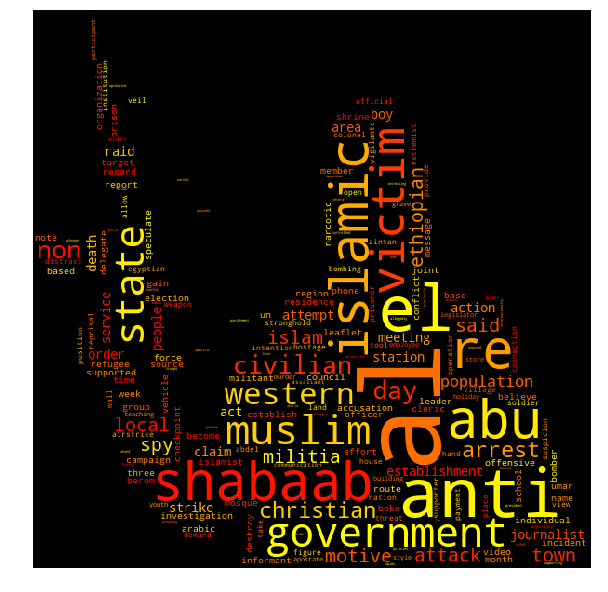

In [81]:
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017]
df_country = df[df.iyear.isin(years)]

motive=df_country['motive'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words=nltk.tokenize.word_tokenize(motive)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
f1=open("kaggle.png", "wb")
f1.write(codecs.decode(kaggle,'base64'))
f1.close()
img1=imread("kaggle.png")
hcmask1 = img1
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black',mask=hcmask1,colormap="autumn").generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud)
fig=plt.gcf()
fig.set_size_inches(10,15)
plt.axis('off')
plt.show()
#prism,flag,viridis,magma,plasma

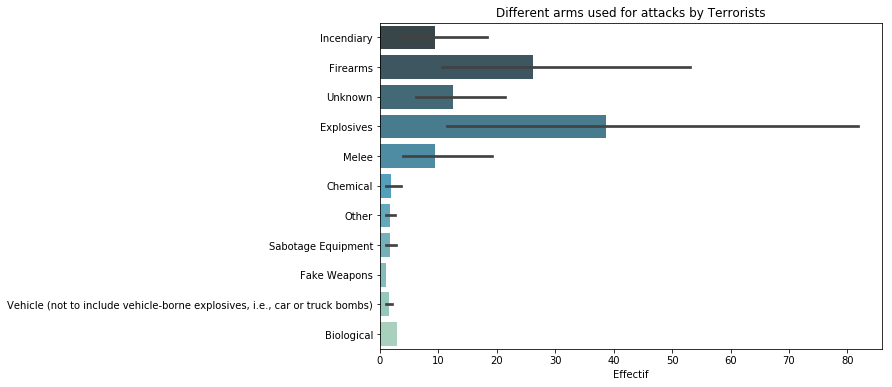

In [24]:
f, ax = plt.subplots(figsize=(9, 6)) 
sns.barplot( y = mode_donne_pays_anne['weaptype1_txt'][1:],
            x = mode_donne_pays_anne['Effectif'][1:],
                palette="GnBu_d")
ax.set_ylabel('')
ax.set_title('Different arms used for attacks by Terrorists' );

In [45]:
Attaque_pays=donnee[donnee.country_txt.isin(pays)].groupby(['country_txt','iyear'], as_index=False)[["attacktype1_txt","attacktype2_txt","attacktype3_txt"]].count()

In [46]:
Attaque_pays["attaque_totale"]=Attaque_pays[["attacktype1_txt","attacktype2_txt","attacktype3_txt"]].sum(axis = 1)

In [16]:
#Attaque_pays

In [47]:
#Mode par acteur selon les années
Mode_Attaque_pays_Annee=donnee[donnee.country_txt.isin(pays)].groupby(['gname',"weaptype1_txt",'iyear'], as_index=False)["attacktype1_txt"].count()

In [48]:
#Mode par acteur
Mode_Attaque_pays=donnee[donnee.country_txt.isin(pays)].groupby(['gname',"weaptype1_txt"], as_index=False)["attacktype1_txt"].count()

In [25]:
#Mode_Attaque_pays